# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from statistics import mean


# Funzioni utili

In [10]:
# Function to remove specified item from a list
def remove_items(test_list, item):
    c = test_list.count(item)
    for i in range(c):
            test_list.remove(item)
    return test_list

# Dataset Utenti

##### Abbiamo a disposizione un dataset di 120 bambini e adolescenti di cui ci vengono forniti alcuni dati anagrafici/clinici (tra cui la feature obiettivo). Inoltre ogni persona ha svolto un test di scrittura che mostreremo successivamente.

In [5]:
users_df = pd.read_csv("users.txt", sep = "\t", dtype = str)
users_df

,ID,diag,sex,hand,age
0,00006,DYSGR,F,R,15
1,00007,DYSGR,M,R,15
2,00008,DYSGR,M,R,14
3,00011,DYSGR,M,R,8
4,00013,DYSGR,M,R,14
...,...,...,...,...,...
115,00187,0,M,R,15
116,00189,0,M,L,15
117,00190,0,F,R,15
118,00191,0,F,R,15


#### Label Encoding sulle feature binarie

In [6]:
# Encoding function
def encodeCategorical(column, data):
    
    dataset = data
    
    valuesList = dataset[column].values
    valuesList = list(dict.fromkeys(valuesList))
    
    encoder = LabelEncoder()
    encoder.fit(valuesList)
    
    encoded = encoder.transform(dataset[column])
    for i in dataset.index:
        dataset.at[i, column] = encoded[i]
        
    return dataset

In [7]:
# Encoding diag, sex, hand features
users_df = encodeCategorical("diag", users_df)
users_df = encodeCategorical("sex", users_df)
users_df = encodeCategorical("hand", users_df)
users_df

,ID,diag,sex,hand,age
0,00006,1,0,0,15
1,00007,1,1,0,15
2,00008,1,1,0,14
3,00011,1,1,0,8
4,00013,1,1,0,14
...,...,...,...,...,...
115,00187,0,1,0,15
116,00189,0,1,1,15
117,00190,0,0,0,15
118,00191,0,0,0,15


# Dataset Sessioni

#### Visualizziamo ora i testi scritti da ogni persona che chiameremo sessioni. Ogni sessione prevede lo stesso testo scritto e i dati sono stati raccolti tramite tavoletta grafica. 

In [8]:
# Function to get user session by specifing row in user_df
def getSession(row) :
    user_id = users_df.loc[row,"ID"]

    session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
    session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio'] 
    session.drop("spazio", axis = 1, inplace = True)

    return session

#### Poichè non abbiamo a disposizione direttamente il disegno ma una matrice che associa vari dati di interesse ad ogni istante temporale, dobbiamo occuparci di ricostruire da questi valori la rappresentazione grafica del testo.

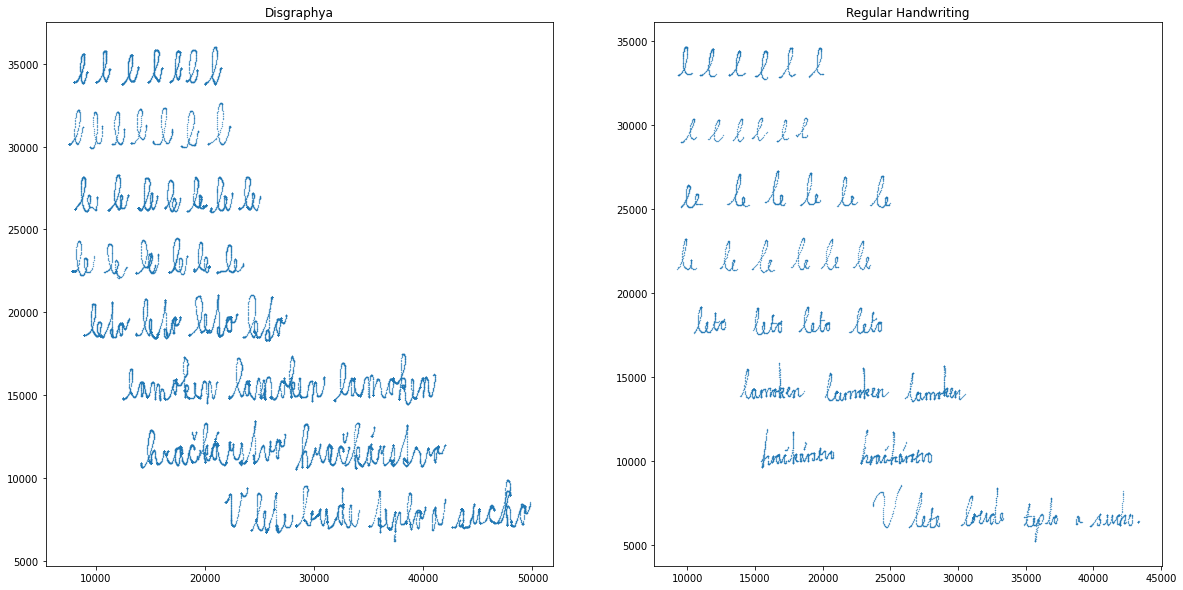

In [31]:
# Initializing plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))

# Getting random session with disgraphya
row=3
user_id = users_df.loc[row,"ID"]
session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
session.drop("spazio", axis = 1, inplace = True)
session.drop(session.index[session['touch'] == 0], inplace=True)  # Dropping data points where there's no pen's touch
# plotting the points
ax1.scatter(session['x'], session['y'],s=0.1)
ax1.set_title('Disgraphya')

# Getting random session without disgraphya
row=22
user_id = users_df.loc[row,"ID"]
session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
session.drop("spazio", axis = 1, inplace = True)
session.drop(session.index[session['touch'] == 0], inplace=True)  # Dropping data points where there's no pen's touch
# plotting the points
ax2.scatter(session['x'], session['y'],s=0.1)
ax2.set_title('Regular Handwriting')

# function to show the plot
plt.show()

#### Salviamo preventivamente tutte le rappresentazioni grafiche che abbiamo ricostruito perchè torneranno utili successivamente.

In [ ]:
# Graphs save
for row in range(120) :
    fig, ax = plt.subplots(figsize=(20, 20))

    session = getSession(row)
    
    xList = []
    yList = []
    countAll = 0
    countTouch = 1

    for touch in session['touch'] :
        if touch!=0 :
            xList.append(session['x'][countAll])
            yList.append(session['y'][countAll])
        else :
            plt.plot(xList,yList,color='black',linewidth=1)
            xList = []
            yList = []
        countAll+=1
        
    plt.axis('off')
    plt.close()
    fig.savefig("Paintings/row"+str(row))

# Analisi delle singole sessioni ed estrazione di nuove feature

#### Passiamo ora a valutare quali feature possiamo ricavare partendo dai dati a disposizione nelle singole sessioni.

In [9]:
# Showing 1 session
getSession(1)

,x,y,time,touch,azimuth,altitude,pressure
0,9410,34548,733391065,1,1280,450,120
1,9410,34548,733391073,1,1280,450,153
2,9410,34548,733391080,1,1280,450,176
3,9410,34548,733391088,1,1280,450,186
4,9410,34548,733391095,1,1290,450,191
...,...,...,...,...,...,...,...
19937,47399,8173,733554243,1,1360,540,307
19938,47431,8198,733554251,1,1360,540,302
19939,47454,8221,733554258,1,1360,540,281
19940,47465,8241,733554266,1,1360,540,235


#### La variabile "touch" giocherà un ruolo fondamentale nelle operazioni successive poichè essa specifica se la penna è poggiata o meno sulla tavoletta.

## Estrazione nuove feature

#### Le persone disgrafiche hanno difficoltà a scrivere entro i limiti stabiliti dal foglio perciò calcoliamo i valori massimi di x,y in tutta la sessione, nella speranza di trovare forti anomalie.

In [33]:
# Function to get the min/max value for both x,y in a specific session
def getMinMax(session):
    
    xCol = session['x'].tolist()
    yCol = session['y'].tolist()
    
    maxX = max(xCol)
    minX = min(xCol)
    
    maxY = max(yCol)
    minY = min(yCol)
    
    return maxX, minX, maxY, minY

#### Le tre funzioni successive calcolano media, mediana e varianza dei valori di pressione, altitudine e azimuth. Qui entra in gioco la variabile "touch" già citata che ci permette di droppare tutte le righe in cui essa è a 0 per evitare di compromettere questi calcoli.

In [34]:
# Function to get the mean and var value for pressure in a specific session 
def getPressureFeatures(session):
    pressures = session['pressure'].tolist()
    pressures = remove_items(pressures, 0)
    
    mean = np.mean(pressures)
    median = np.median(pressures)
    var = np.var(pressures)
    
    return mean, median, var

In [35]:
# Function to get the mean and var value for altitude in a specific session 
def getAltitudeFeatures(session):
    altitudes = session['altitude'].tolist()
    altitudes = remove_items(altitudes, 0)
    
    mean = np.mean(altitudes)
    median = np.median(altitudes)
    var = np.var(altitudes)
    
    return mean, median, var

In [36]:
# Function to get the mean and var value for altitude in a specific session 
def getAzimuthFeatures(session):
    azimuthes = session['azimuth'].tolist()
    azimuthes = remove_items(azimuthes, 0)
    
    mean = np.mean(azimuthes)
    median = np.median(azimuthes)
    var = np.var(azimuthes)
    
    return mean, median, var

#### Calcoliamo il tempo impiegato per la sessione e il numero di volte che è stata sollevata la penna. Per i soggetti disgrafici ci aspettiamo valori più alti in etrambi i casi.

In [37]:
# Function to get specific session time
def getDuration(session):
    timestamps = session['time'].tolist()
    
    first = int(timestamps[0])
    last = int(timestamps.pop())
        
    duration = (last-first)/1000
            
    return str(duration)

In [38]:
# Function to get pen lift counter
def getPenLift(session):
    liftCounter = 1
    liftIndicator = 1
    for elem in session['touch']:
        if elem != 0:
            liftIndicator = 1
        else:
            if liftIndicator != 0:
                liftCounter += 1
                liftIndicator = 0
    return liftCounter

#### Definiamo un segmento come un tratto di penna continuo, e ci andiamo a calcolare i valori medi e massimi di dimensione e durata temporale dei diversi segmenti della sessione alla richerca di eventuali valori fuori dalla norma.

In [39]:
# Counting x,y,duration for each segment
countTouchList = []
xList=[]
yList=[]
strokeList=[]

xSegmentMax = []
ySegmentMax = []
durationSegmentMax = []

xSegmentAvg = []
ySegmentAvg = []
durationSegmentAvg = []

for row in range(120) :

    xListSegment = []
    yListSegment = []
    strokeDuration = []
    startStroke = 0
    countAll = 0
    countTouch = 1
    minX = 0
    maxX = 0
    minY = 0
    maxY = 0

    user_id = users_df.loc[row,"ID"]
    session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
    session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
    session.drop("spazio", axis = 1, inplace = True)

    for touch in session['touch'] :
        if touch!=0 :
            if countTouch :
                startStroke=session['time'][countAll]
                minX=session['x'][countAll]
                maxX=session['x'][countAll]
                minY=session['y'][countAll]
                maxY=session['y'][countAll]
            else :
                if session['x'][countAll] < minX :
                    minX=session['x'][countAll]
                if session['x'][countAll] > maxX :
                    maxX=session['x'][countAll]
                if session['y'][countAll] < minY :
                    minY=session['y'][countAll]
                if session['y'][countAll] > maxY :
                    maxY=session['y'][countAll]
            countTouch = 0
        else :
            if countTouch==0 :
                xListSegment.append(maxX-minX)
                yListSegment.append(maxY-minY)
                strokeDuration.append(session['time'][countAll]-startStroke)
                countTouch=1
        countAll+=1

    xSegmentMax.append(max(xListSegment))
    ySegmentMax.append(max(yListSegment))
    durationSegmentMax.append(max(strokeDuration))

    xSegmentAvg.append(mean(xListSegment))
    ySegmentAvg.append(mean(yListSegment))
    durationSegmentAvg.append(mean(strokeDuration))

    xList.append(xListSegment)
    yList.append(yListSegment)
    strokeList.append(strokeDuration)

#### Il numero di intersezioni durante la scrittura è un dato potenzialmente interessante poichè è abbastanza comune nei soggetti disgrafici tornare su porzioni di testo già scritte.

In [ ]:
# Calculating Inteserction Occurances
intersectionList=[]

for row in range(120) :
    user_id = users_df.loc[row,"ID"]
    session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)

    session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
    session.drop("spazio", axis = 1, inplace = True)

    pointer = 0
    subpointer = 0
    count = 0
    countAll = 0
    index = 0
    sli=0
    sliCount=0

    cols = ["x","y"]
    session = session[cols].loc[(session[cols].shift() != session[cols]).any(axis=1)]
    session = session.reset_index()
    session.drop("index", axis=1, inplace=True)
    
    for x1 in session['x']:
        subpointer=pointer+1
        df = session.iloc[subpointer:,:3]
        index = subpointer
        for x2 in df['x']:
            if x1==x2 and session['y'][pointer]==session['y'][subpointer]:
                if subpointer!=index :
                    count+=1
                    index=subpointer+1
                else :
                    index+=1
            subpointer+=1
        pointer+=1
    intersectionList.append(count)

## Aggiornamento del dataset utenti con le nuove feature

In [40]:
# Local variables to store new feature values
maxXcol = []
minXcol = []
maxYcol = []
minYcol = []

pressureMean = []
pressureVar = []
pressureMedian = []

altitudeMean = []
altitudeVar = []
altitudeMedian = []

azimuthMean = []
azimuthVar = []
azimuthMedian = []

penLifts = []

durations = []

# Calculating new feature values
for i in range(0, len(users_df)):
    session = getSession(i)

    maxX, minX, maxY, minY = getMinMax(session)
    maxXcol.append(maxX)
    minXcol.append(minX)
    maxYcol.append(maxY)
    minYcol.append(minY)

    mean, median, var = getPressureFeatures(session)
    pressureMean.append(mean)
    pressureVar.append(var)
    pressureMedian.append(median)

    mean, median, var = getAltitudeFeatures(session)
    altitudeMean.append(mean)
    altitudeVar.append(var)
    altitudeMedian.append(median)

    mean, median, var = getAzimuthFeatures(session)
    azimuthMean.append(mean)
    azimuthVar.append(var)
    azimuthMedian.append(median)

    liftCounter = getPenLift(session)
    penLifts.append(liftCounter)

    duration = getDuration(session)
    durations.append(duration)

In [41]:
# Fill max/min x,y columns
users_df["max_X"] = maxXcol
users_df["min_X"] = minXcol
users_df["max_Y"] = maxYcol
users_df["min_Y"] = minYcol

# Fill  segment max/avg length for each session
users_df["xMaxSegment"] = xSegmentMax
users_df["yMaxSegment"] = ySegmentMax
users_df["durationSegmentMax"] = durationSegmentMax

users_df["xAvgSegment"] = xSegmentAvg
users_df["yAvgSegment"] = ySegmentAvg
users_df["durationAvgSegment"] = durationSegmentAvg

# Fill mean, median and var pressure columns
users_df["mean_pressure"] = pressureMean
users_df["var_pressure"] = pressureVar
users_df["median_pressure"] = pressureMedian

# Fill mean, median and var altitude columns
users_df["mean_altitude"] = altitudeMean
users_df["var_altitude"] = altitudeVar
users_df["median_altitude"] = altitudeMedian

# Fill mean, median and var azimuth columns
users_df["mean_azimuth"] = azimuthMean
users_df["var_azimuth"] = azimuthVar
users_df["median_azimuth"] = azimuthMedian

# FIll duration column
users_df["duration"] = durations

# Fill touchCounter column
users_df["penLifts"] = penLifts

# Fill Inteserction column
users_df["intersectionsCount"] = intersectionList

# Save updated dataset
users_df.to_csv('updatedDataset.csv', index=False)

# Show updated dataset
users_df

,ID,diag,sex,hand,age,max_X,min_X,max_Y,min_Y,xMaxSegment,...,median_pressure,mean_altitude,var_altitude,median_altitude,mean_azimuth,var_azimuth,median_azimuth,duration,penLifts,intersectionsCount
0,00006,1,0,0,15,56794,11888,39045,4646,8219,...,482.0,623.924548,623.924548,580.0,1420.354727,1420.354727,1380.0,132.896,73,1
1,00007,1,1,0,15,47465,9054,36578,7019,5721,...,281.0,586.073112,586.073112,510.0,1362.700931,1362.700931,1300.0,163.208,62,21
2,00008,1,1,0,14,48469,12428,36672,7252,6349,...,401.0,681.420902,681.420902,660.0,1220.450336,1220.450336,1180.0,106.014,49,5
3,00011,1,1,0,8,49767,7062,36009,5641,9227,...,522.0,593.598292,593.598292,550.0,862.982325,862.982325,750.0,388.567,62,44
4,00013,1,1,0,14,42992,11271,34611,4997,7471,...,210.0,573.814058,573.814058,530.0,891.518851,891.518851,810.0,190.817,43,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,00187,0,1,0,15,41355,8091,36418,6673,5987,...,196.0,601.991578,601.991578,550.0,1005.398529,1005.398529,950.0,124.248,53,11
116,00189,0,1,1,15,42528,9470,34956,6738,5272,...,617.0,672.806750,672.806750,640.0,2863.715956,2863.715956,2940.0,140.945,56,11
117,00190,0,0,0,15,39601,6639,35109,6691,3887,...,290.0,570.729136,570.729136,550.0,1028.805477,1028.805477,1000.0,96.349,55,3
118,00191,0,0,0,15,39210,11106,35718,5610,3779,...,358.0,555.266748,555.266748,510.0,834.625455,834.625455,760.0,118.521,68,13


## Estrazione feature tramite CNN

#### Utilizziamo una tecnica di "transfer learning" che permette di sfruttare una rete preaddestrata (noi abbiamo utilizzato la VGG16 addestrata con il dataset imageNet). Questo approccio permette di estrarre le feature presenti al penultimo livello della rete neurale. 

In [ ]:
# example of using the vgg16 model as a feature extraction model
import tensorflow as tf
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
import pandas as pd

df = pd.DataFrame()
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
for row in range(120) :
    image = load_img('Paintings/row'+str(row)+'.png', target_size=(224, 224))
# convert the image pixels to a numpy array
    image = img_to_array(image)
# reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
    image = preprocess_input(image)
# get extracted features
    features = model.predict(image)
    df1 = pd.DataFrame(features)
    df =  pd.concat([df, df1], ignore_index=True)

users_df = pd.read_csv("users.txt", sep = "\t", dtype = str)
df["diag"]=users_df["diag"]
df.to_csv("CNNFeatureExtraction.csv")

#### Otteniamo dunque un nuovo dataset che verrà utilizzato in fase di classificazione in alternativa a quello calcolato precedentemente e confronteremo i risultati ottenuti con i diversi approcci.

### Label Encoding e drop colonna "Unnamed"

In [13]:
feature_df = pd.read_csv("CNNFeatureExtraction.csv")
feature_df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,diag
0,0,0.0,0.476364,2.021005,0.000000,0.0,0.0,1.254847,0.0,0.0,...,0.0,0.562406,2.212516,0.0,0.000000,0.000000,0.0,0.0,1.675844,DYSGR
1,1,0.0,1.389860,1.540506,0.000000,0.0,0.0,0.889042,0.0,0.0,...,0.0,0.657190,2.172288,0.0,0.000000,0.076214,0.0,0.0,1.661323,DYSGR
2,2,0.0,0.665737,2.095717,0.420907,0.0,0.0,1.225297,0.0,0.0,...,0.0,0.949780,2.475492,0.0,0.351266,0.885684,0.0,0.0,1.072596,DYSGR
3,3,0.0,0.666845,1.767537,0.000000,0.0,0.0,1.318399,0.0,0.0,...,0.0,0.487599,2.173002,0.0,0.384365,0.233874,0.0,0.0,1.723757,DYSGR
4,4,0.0,1.029708,1.438789,0.280909,0.0,0.0,0.553397,0.0,0.0,...,0.0,1.150887,2.766512,0.0,0.000000,0.049240,0.0,0.0,2.183215,DYSGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,0.0,0.149788,1.602545,0.000000,0.0,0.0,1.099700,0.0,0.0,...,0.0,0.981983,2.833213,0.0,0.000000,0.000000,0.0,0.0,1.840923,0
116,116,0.0,0.486703,1.218230,0.000000,0.0,0.0,0.062853,0.0,0.0,...,0.0,0.810484,3.355525,0.0,0.000000,0.000000,0.0,0.0,2.068771,0
117,117,0.0,0.733697,1.766390,0.000000,0.0,0.0,0.481217,0.0,0.0,...,0.0,0.424269,2.923444,0.0,0.000000,0.000000,0.0,0.0,1.504338,0
118,118,0.0,0.793203,1.739536,0.000000,0.0,0.0,0.944208,0.0,0.0,...,0.0,0.135666,2.272999,0.0,0.000000,0.000000,0.0,0.0,2.092904,0


In [14]:
feature_df.drop(["Unnamed: 0"], axis=1, inplace=True)
feature_df = encodeCategorical("diag", feature_df)

feature_df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,diag
0,0.0,0.476364,2.021005,0.000000,0.0,0.0,1.254847,0.0,0.0,0.0,...,0.0,0.562406,2.212516,0.0,0.000000,0.000000,0.0,0.0,1.675844,1
1,0.0,1.389860,1.540506,0.000000,0.0,0.0,0.889042,0.0,0.0,0.0,...,0.0,0.657190,2.172288,0.0,0.000000,0.076214,0.0,0.0,1.661323,1
2,0.0,0.665737,2.095717,0.420907,0.0,0.0,1.225297,0.0,0.0,0.0,...,0.0,0.949780,2.475492,0.0,0.351266,0.885684,0.0,0.0,1.072596,1
3,0.0,0.666845,1.767537,0.000000,0.0,0.0,1.318399,0.0,0.0,0.0,...,0.0,0.487599,2.173002,0.0,0.384365,0.233874,0.0,0.0,1.723757,1
4,0.0,1.029708,1.438789,0.280909,0.0,0.0,0.553397,0.0,0.0,0.0,...,0.0,1.150887,2.766512,0.0,0.000000,0.049240,0.0,0.0,2.183215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.149788,1.602545,0.000000,0.0,0.0,1.099700,0.0,0.0,0.0,...,0.0,0.981983,2.833213,0.0,0.000000,0.000000,0.0,0.0,1.840923,0
116,0.0,0.486703,1.218230,0.000000,0.0,0.0,0.062853,0.0,0.0,0.0,...,0.0,0.810484,3.355525,0.0,0.000000,0.000000,0.0,0.0,2.068771,0
117,0.0,0.733697,1.766390,0.000000,0.0,0.0,0.481217,0.0,0.0,0.0,...,0.0,0.424269,2.923444,0.0,0.000000,0.000000,0.0,0.0,1.504338,0
118,0.0,0.793203,1.739536,0.000000,0.0,0.0,0.944208,0.0,0.0,0.0,...,0.0,0.135666,2.272999,0.0,0.000000,0.000000,0.0,0.0,2.092904,0


In [15]:
df.to_csv("CNNFeatureExtraction.csv")